# Mental-Health Patient Dashboard & Questionnaire Service

#### Jordyn Brooks

**Purpose**: Enables clinicians to view a patient’s core data (demographics, vitals, meds, allergies) and flags mental-health concerns via a CDS Hook

### FHIR Data Exploration

In [1]:
import pandas as pd
import pymongo
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from utils import connect, load_patient_ids
# --- MongoDB Connection ---
client = pymongo.MongoClient("mongodb://localhost:27017")
DB_NAME = "ehr_db" 
db = client[DB_NAME]
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ehr_db')

In [2]:
patients = list(db['Patient'].find())
df_pat = pd.DataFrame(patients)
print("Patient Count:", len(df_pat))

Patient Count: 120


In [3]:
from bson.objectid import ObjectId
example = db['Condition'].find_one({'_id': ObjectId('67e417c528bcc6dd45aa1028')})
print(example.get('code', {}))

{'coding': [{'system': 'http://snomed.info/sct', 'code': '65363002', 'display': 'Otitis media'}], 'text': 'Otitis media'}


Maximum age: 109
Minimum age: 4


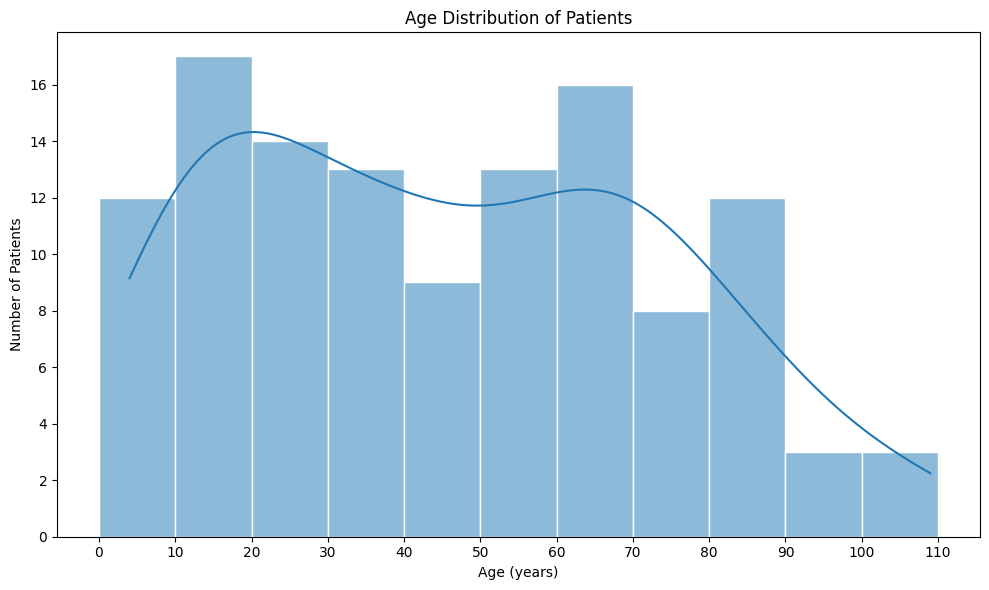

In [4]:
# Age distribution
df_pat['birthDate'] = pd.to_datetime(df_pat['birthDate'], errors='coerce')

today = pd.to_datetime('today')
df_pat['age'] = ((today - df_pat['birthDate']).dt.days // 365).astype(int)

df_pat = df_pat.dropna(subset=['age'])

max_age = df_pat['age'].max()
min_age = df_pat['age'].min()
print(f'Maximum age: {max_age}')
print(f'Minimum age: {min_age}')
bins = range(0, (max_age // 10 + 2) * 10, 10)

plt.figure(figsize=(10, 6))
sns.histplot(
    df_pat['age'],
    bins=bins,        # decade bins
    kde=True,         # overlay density
    edgecolor='w'
)
plt.xlabel('Age (years)')
plt.ylabel('Number of Patients')
plt.title('Age Distribution of Patients')
plt.xticks(bins)

plt.tight_layout()
plt.show()

gender
female    68
male      52
Name: count, dtype: int64


/var/folders/1w/gghvz6jx6n34v_rjgj5t31p80000gn/T/ipykernel_19386/4029342150.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


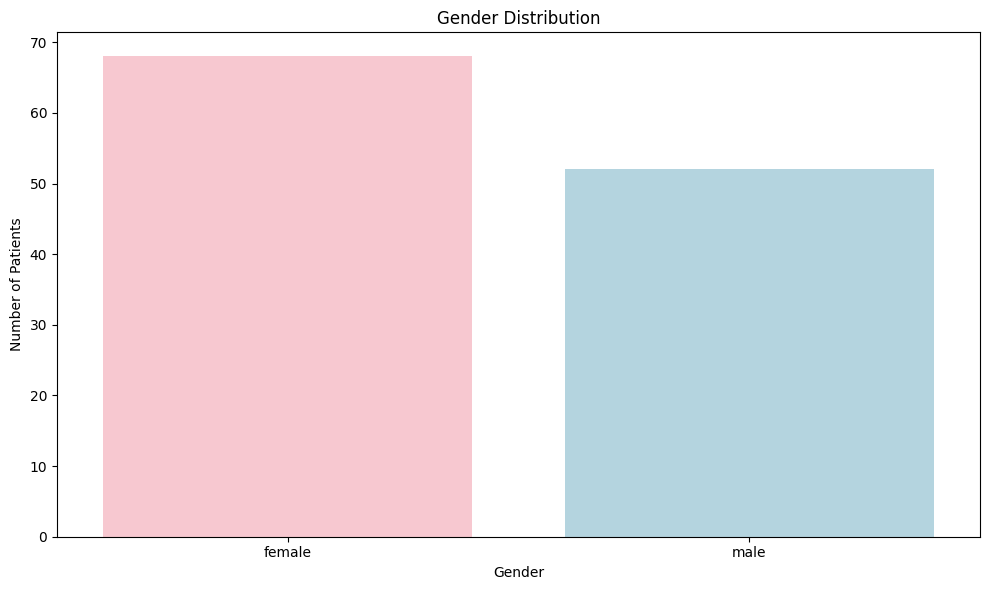

In [5]:
# Gender Distribution
print(df_pat['gender'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(
    x='gender',
    data=df_pat,
    order=['female', 'male'],
    palette={'female': 'pink', 'male': 'lightblue'}
)
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

/var/folders/1w/gghvz6jx6n34v_rjgj5t31p80000gn/T/ipykernel_19386/932345399.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


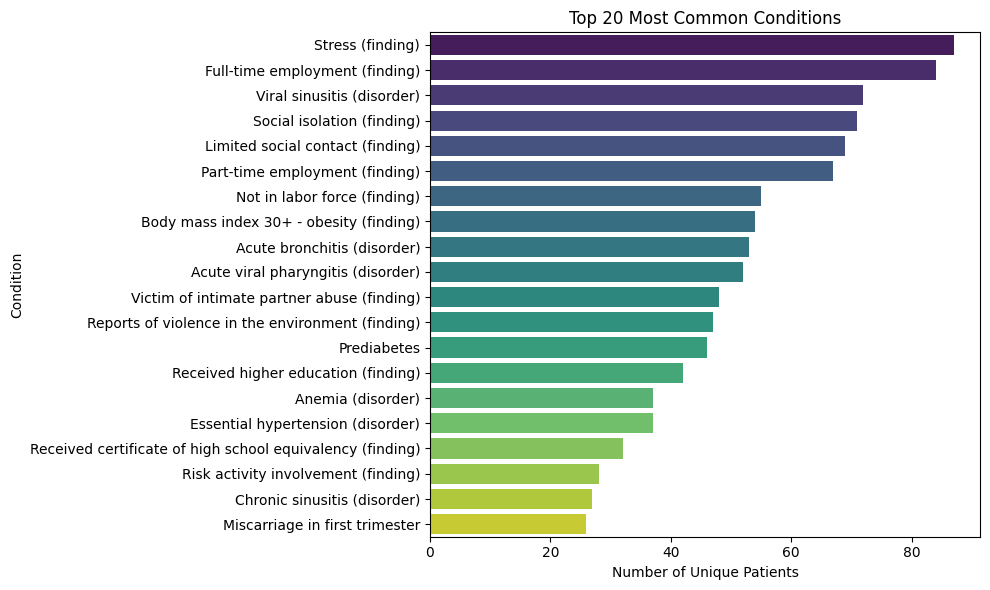

In [16]:
# Looking at top conditions
conds = list(db['Condition'].find())

df_cond = pd.DataFrame([{
    'patient_id': c['subject']['reference'].split('/')[-1],
    'diagnosis': c.get('code', {}).get('text', 'Unknown')
} for c in conds])

df_summary = (
    df_cond
      .dropna(subset=['diagnosis'])
      .groupby('diagnosis')['patient_id']
      .nunique()
      .reset_index(name='count')
      .sort_values('count', ascending=False)
)

top20 = df_summary.head(20)

# 6. BAR CHART: top 10 conditions
plt.figure(figsize=(10, 6))
sns.barplot(
    y='diagnosis',
    x='count',
    data=top20,
    palette='viridis'        # or pick any seaborn palette
)
plt.xlabel('Number of Unique Patients')
plt.ylabel('Condition')
plt.title('Top 20 Most Common Conditions')
plt.tight_layout()
plt.show()

/var/folders/1w/gghvz6jx6n34v_rjgj5t31p80000gn/T/ipykernel_19386/2791160270.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


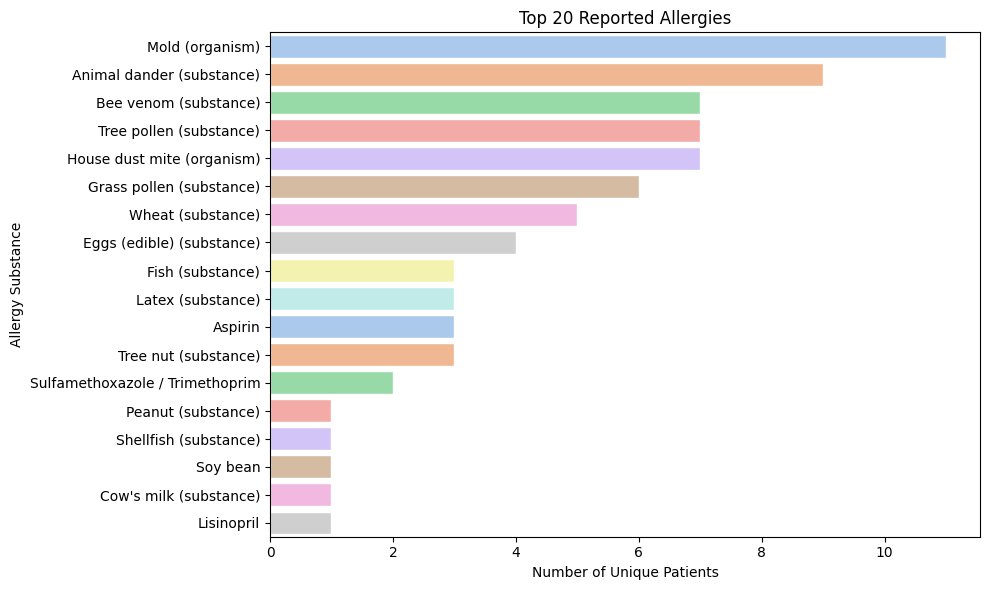

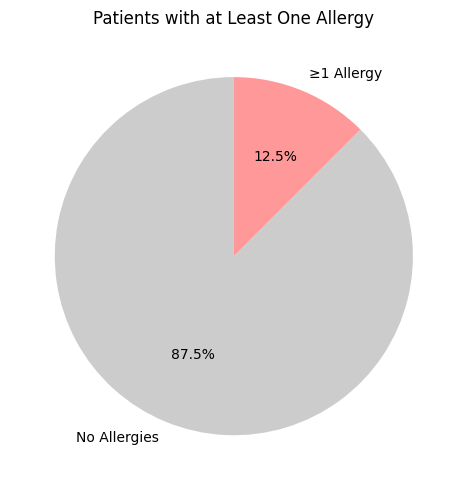

In [19]:
# Common Allergies
allergies = list(db['AllergyIntolerance'].find())

df_allergy = pd.DataFrame([{
    'patient_id': a['patient']['reference'].split('/')[-1],
    # depending on your data, 'code' might be under 'code.text' or 'substance.text'
    'substance': a.get('code', {}).get('text', 'Unknown')
} for a in allergies])

df_allergy = df_allergy[df_allergy['substance'].notna()]

df_summary = (
    df_allergy
      .groupby('substance')['patient_id']
      .nunique()
      .reset_index(name='count')
      .sort_values('count', ascending=False)
)

top10 = df_summary.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(
    y='substance',
    x='count',
    data=top10,
    palette='pastel',
    edgecolor='w'
)
plt.xlabel('Number of Unique Patients')
plt.ylabel('Allergy Substance')
plt.title('Top 20 Reported Allergies')
plt.tight_layout()
plt.show()

has_allergy = set(df_allergy['patient_id'])
df_pat['has_allergy'] = df_pat['id'].isin(has_allergy)

sizes = df_pat['has_allergy'].value_counts()
labels = ['No Allergies','≥1 Allergy']
colors = ['#CCCCCC','#FF9999'] 

plt.figure(figsize=(5,5))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Patients with at Least One Allergy')
plt.tight_layout()
plt.show()

/var/folders/1w/gghvz6jx6n34v_rjgj5t31p80000gn/T/ipykernel_19386/4171410555.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


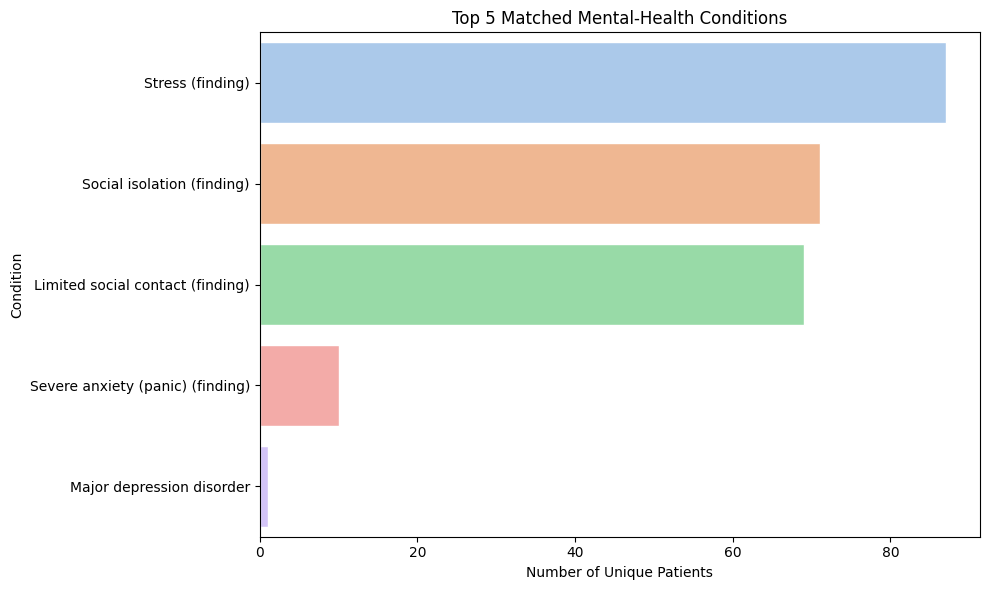

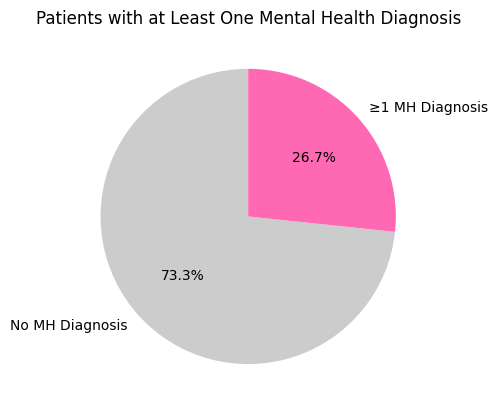

In [22]:
# Mental health conditions
keywords = [
    # mood disorders
    'depression', 'bipolar',  
    # anxiety‐related
    'anxiety', 'panic', 'phobia', 'social anxiety',  
    # trauma & stress
    'ptsd', 'adjustment disorder', 'stress',
    # personality & impulse
    'bpd', 'ocd',  
    # psychotic
    'schizophrenia', 'schizoaffective', 'psychosis', 'manic', 
    # neurodevelopmental
    'adhd',  
    # eating disorders
    'eating disorder', 'anorexia', 'bulimia',  
    # substance‐related
    'substance use', 'addiction', 'alcohol use',  
    # sleep & other
    'insomnia', 'social isolation', 'limited social contact'
]

conds = list(db['Condition'].find({
    '$or': [
        {'code.text': {'$regex': kw, '$options': 'i'}}
        for kw in keywords
    ]
}))

df_cond = pd.DataFrame([{
    'patient_id': c['subject']['reference'].split('/')[-1],
    'diagnosis': c['code']['text']
} for c in conds])

df_cond = df_cond[~df_cond['diagnosis'].str.contains('distress', case=False, na=False)]

def match_kw(text):
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return kw
    return None

df_diag_summary = (
    df_cond
      .dropna(subset=['diagnosis'])
      .groupby('diagnosis')['patient_id']
      .nunique()
      .reset_index(name='count')
      .sort_values('count', ascending=False)
)

top5 = df_diag_summary.head(5)

plt.figure(figsize=(10, 6))
sns.barplot(
    y='diagnosis',   
    x='count',
    data=top5,
    palette='pastel',
    edgecolor='w'
)
plt.xlabel('Number of Unique Patients')
plt.ylabel('Condition')
plt.title('Top 5 Matched Mental-Health Conditions')
plt.tight_layout()
plt.show()

has_any = set(df_cond['patient_id'])
df_pat['has_mental_dx'] = df_pat['id'].isin(has_any)

sizes = df_pat['has_mental_dx'].value_counts()
labels = ['No MH Diagnosis', '≥1 MH Diagnosis']
colors = ['#CCCCCC','#FF69B4']  # grey vs hotpink, for example

plt.figure(figsize=(5,5))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Patients with at Least One Mental Health Diagnosis')
plt.tight_layout()
plt.show()

In [23]:
# Looking for patient ID's with at least 1 dgx
counts = (
    df_cond
      .groupby('patient_id')
      .size()
      .reset_index(name='mh_count')
)

# Filter to those with >1
multi_dx = counts[counts['mh_count'] >= 1]['patient_id'].tolist()

print(len(multi_dx))
#print(multi_dx)

88


In [10]:
# Looking for patients specifically with a anxiety diagnosis
anxiety_df = df_cond[
    df_cond['diagnosis']
      .str
      .contains('anxiety', case=False, na=False)
]

anxiety_patient_ids = anxiety_df['patient_id'].unique().tolist()

print(len(anxiety_patient_ids))
print(anxiety_patient_ids)

10
['ef04d7bf-2139-3c3b-9a8d-5806f78544cf', '6c9c8bdd-b07a-d183-8c2c-0d53f3036f96', '76fbb143-baad-cc88-fa9f-b8d1c63e6a9b', '6808d051-b198-499b-1699-f502c331c9ae', '42618df6-53ac-d2d7-6281-1ab4094bc26c', 'd85ff42e-0ff4-8a75-8a13-4f22e7055987', '7d9aa431-cd72-8aa2-9559-5920937d9330', '9c29d9d1-ff28-b22c-461d-431d953326e3', '79a66c97-6131-3213-f3c9-4606946ab056', 'f6443152-1ea7-5cc1-c426-28ba3cb0fefa']


In [14]:
# Looking for patients specifically with a anxiety diagnosis
depress_df = df_cond[
    df_cond['diagnosis']
      .str
      .contains('depression', case=False, na=False)
]

depression_patient_ids = depress_df['patient_id'].unique().tolist()

print(len(depression_patient_ids))
print(depression_patient_ids)

1
['bc888c14-1c99-e323-8ab4-dd822f21b60b']


In [11]:
# Looking at how many people have existing PHQ-9 or GAD-7 scores
from utils import connect           # :contentReference[oaicite:0]{index=0}&#8203;:contentReference[oaicite:1]{index=1}
import pandas as pd
from collections import Counter

client, db = connect()

loinc_map = {
    "44249-1": "PHQ-9 Panel",
    "44261-6": "PHQ-9 Total Score",
    "69737-5": "GAD-7 Panel",
    "70274-6": "GAD-7 Total Score",
}
loinc_codes = list(loinc_map.keys())

cursor = db["Observation"].find({
    "code.coding.system": "http://loinc.org",
    "code.coding.code": {"$in": loinc_codes}
})
records = list(cursor)

total_assessments = len(records)
print(f"Total number of PHQ-9 & GAD-7 assessments across all patients: {total_assessments}")

codes = []
for obs in records:
    for coding in obs.get("code",{}).get("coding",[]):
        if (coding.get("system")=="http://loinc.org"
            and coding.get("code") in loinc_codes):
            codes.append(coding["code"])
counts = Counter(codes)

# 6. build a DataFrame for easy viewing
df_counts = (pd.DataFrame.from_dict(counts, orient="index", columns=["count"])
               .rename_axis("loinc_code")
               .reset_index())
df_counts["label"] = df_counts["loinc_code"].map(loinc_map)
df_counts = df_counts[["loinc_code","label","count"]]

df_counts

Total number of PHQ-9 & GAD-7 assessments across all patients: 533


,loinc_code,label,count
0,70274-6,GAD-7 Total Score,493
1,44261-6,PHQ-9 Total Score,40


533


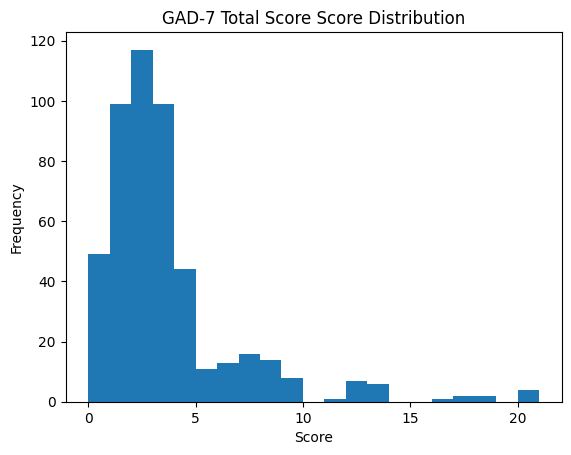

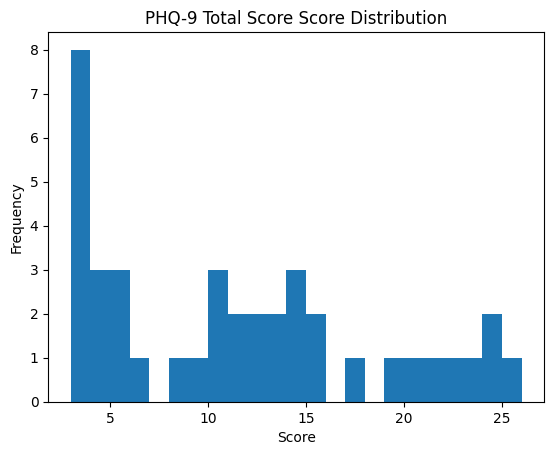

In [12]:
# Looking at distribution of PHQ-9 and GAD-7 scores across all patients
from utils import connect           
import pandas as pd
import matplotlib.pyplot as plt

client, db = connect()
loinc_totals = {
    "44261-6": "PHQ-9 Total Score",   # :contentReference[oaicite:2]{index=2}
    "70274-6": "GAD-7 Total Score",    # :contentReference[oaicite:3]{index=3}
}

cursor = db["Observation"].find({
    "code.coding.system": "http://loinc.org",
    "code.coding.code": {"$in": list(loinc_totals.keys())}
})
records = list(cursor)

count = 0
rows = []
for obs in records:
    score = obs.get("valueQuantity", {}).get("value")
    # find the matching code
    for coding in obs.get("code", {}).get("coding", []):
        code = coding.get("code")
        if code in loinc_totals:
            rows.append({
                "test": loinc_totals[code],
                "score": score
            })
            count+=1
            break

print(count)
df = pd.DataFrame(rows)

for test_name in df["test"].unique():
    sub = df[df["test"] == test_name]["score"]
    plt.figure()
    plt.hist(sub, bins=range(int(sub.min()), int(sub.max())+2))  # integer bins
    plt.title(f"{test_name} Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()